# Reinforcement Learning Introduction
## Tabular Q-Learning
(by: [Nicolaj Stache](mailto:Nicolaj.Stache@hs-heilbronn.de), and [Pascal Graf](mailto:pascal.graf@hs-heilbronn.de), both: Heilbronn University, Germany, June 2022) 

In this notebook we look at a simple reinforcement learning problem and the tabular Q-Learning algorithm.

<hr>

## Table of Contents:
### 1. [Imports](#imports)

### 2. [Environment](#environment)

### 3. [Training](#training)

### 4. [Evaluation](#evaluation)
<hr>

## 1. Imports <a class="anchor" id="imports"></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## 2. Environment <a class="anchor" id="environment"></a>
The environment we're going to solve is called "Grid World". The respective Python file is stored in a folder along with this notebook. The task is to reach the terminal state that yields a positive reward in a grid with arbitrary size. Every other step in the environment leads to a slight negative reward. There are also obstacles randomly distributed over the environment and a terminal field to avoid which yields a negative reward.
<hr>

**TO DO:** Take a look into the grid_world file and try to understand it.

In [2]:
from envs.grid_world import Grid

### Create a new random Grid World and explore the environment
Initialize the grid environment, then print its structure as well as the the rewards that are obtained reaching each state.
<hr>

**TO DO:** Make sure the target field is reachable. Each function call will create a new random grid.

In [25]:
# Create a new Grid World
grid = Grid(5, 4, step_reward=-0.1, obstacles=3)
# Print grid structure
print("Grid World:")
grid.print_grid()

print("Rewards:")
grid.print_grid_rewards()

Grid World:
------------------------------
     |  x  |     |     |     |
------------------------------
     |     |     |     |     |
------------------------------
     |  t  |     |  x  |  a  |
------------------------------
  x  |     |     |     |  s  |
------------------------------

Rewards:
------------------------------
-0.10| 0.00|-0.10|-0.10|-0.10|
------------------------------
-0.10|-0.10|-0.10|-0.10|-0.10|
------------------------------
-0.10| 1.00|-0.10| 0.00|-1.00|
------------------------------
 0.00|-0.10|-0.10|-0.10|-0.10|



## 3. Training <a class="anchor" id="training"></a>

### Training Parameters
The success of the reinforcement learning algorithm heavily depends of the choice of parameters. Among these are the learning rate $\alpha$, the discount factor $\gamma$ and the exploration parameters. 
<hr>

**TO DO:** After successfully training the algorithm with the default parameters, try modifying `EPSILON`, `EPSILON_DECAY`, `GAMMA` and `ALPHA` to get a feel for their effects on the learning progress.

In [26]:
# Number of training episodes
EPISODES = 10000
# Discount Factor
GAMMA = 0.9
# Learning Rate
ALPHA = 0.05
# Epsilon
EPSILON = 1
# Decay of random actions
EPSILON_DECAY = 0.95
# Action space (Up, Down, Left, Right)
ALL_POSSIBLE_ACTIONS = ('U', 'D', 'L', 'R')

### Q-Learning Algorithm
Q-Learning is an online, off-policy, non-model-based, bootstrapping reinforcement learning algorithm. We will use a modified implementation taken from [here](https://deeplearningcourses.com/c/artificial-intelligence-reinforcement-learning-in-python) in attempt to solve the Grid World environment. Underneath you can see the pseudo code for tabular Q-Learning.


#### Q-Learning Pseudo Code
<hr>

- Initialize:
    - Step Size $\alpha \in (0,1]$ 
    - $Q(s,a)$ dictionary for all $s\in S, a \in A$.
    - $\epsilon > 0$
- Loop for each episode:
    1. Choose $A$ from $S$ using an $\epsilon$-greedy policy.
    2. Take action $A$, observe $R, S'$.
    3. $Q(S,A)\leftarrow Q(S,A) + \alpha [R+\gamma max_a Q(S', a)-Q(S,A)]$
    4. $S\leftarrow S'$
    
    until $S$ is terminal

<hr>





#### Miscellaneous functions

In order to perform and evaluate the training we need some helper functions. 

The **`max_dict`** function accepts a dictionary as parameter, loops through the dictionary and returns the maximum value as well as its key.

The **`act_epsilon_greedy`** function selects an action from a dictionary according to the epsilon-greedy algorithm. This means, in $\epsilon$ percent of the cases it returns a random action, otherwise the action is chosen greedily according to a action-value dictionary.
<hr>


**TO DO:** 
1. Complete the **`max_dict`** function to return the maximum value and its respective key from a dictionary.

2. Complete the **`act_epsilon_greedy`** function to select a random action from `ALL_POSSIBLE_ACTIONS` if a random value is smaller or equal to $\epsilon$. Otherwise act greedily with respect to $Q(s,a)$.

In [27]:
def max_dict(d):
    '''Returns the argmax (key) and max (value) from a dictionary.'''
    max_key = None
    max_val = float('-inf')
    for k, v in d.items():
        if v > max_val:
            max_val = v
            max_key = k
    return max_key, max_val

def act_epsilon_greedy(Qs, eps=0.1):
    '''Selects an epsilon greedy action given the action-values for a state and epsilon.'''
    if np.random.random() <= eps:
        return np.random.choice(ALL_POSSIBLE_ACTIONS)
    a, _ = max_dict(Qs)
    return a

### Training Loop
<hr>

**TO DO:** Complete the following code to correspond to the pseude code above. 

In [28]:
# Set initial exploration
eps = EPSILON

# Initialize an empty dictionary for the action-value function Q(s,a)
Q = {}
# Initialize an empty dictionary for the number of times action a has been chosen in state s.
action_visits = {}
# Initialize an empty dictionary for the number of times state s has been visited.
state_visits = {}

# For each state corresponding to each field in the environment, create a new dictionary inside the dictionaries.
for row in range(grid.height):
    for col in range(grid.width):
        Q[(row, col)] = {}
        action_visits[(row, col)] = {}
        state_visits[(row, col)] = 1
        # For each action in each state create a new entry in the dictonary setting its estimated value to 0 and its visits to 1.
        for a in ALL_POSSIBLE_ACTIONS:
            Q[(row, col)][a] = 0
            action_visits[(row, col)][a] = 1
            
# Keep track of the maximum value changes during each episode so we can plot a learning curve after the training       
deltas = []


# Training Loop
# Play EPISODES number of episodes in the environment while learning after each step.
for e in range(EPISODES):
    # Every 1000 steps print the current episode number and epsilon
    if e % 1000 == 0:
        print("Episode: {}, Epsilon: {}".format(e, eps))
        
    # Decrease epsilon every 100 episodes to approach a more deterministic policy.
    if e % 100 == 0 and eps>0:
        eps *= EPSILON_DECAY

    # Set the starting state
    grid.reset()
    s = grid.get_current_state()

    biggest_change = 0
    while not grid.is_state_terminal():
        # Choose an action epsilon-greedily.
        a = act_epsilon_greedy(Q[s], eps=eps)
        r = grid.move(a)
        next_s = grid.get_current_state()
        
        # Update the state and action visits number.
        state_visits[s] += 1
        action_visits[s][a] += 1

        # Update Q(s,a)
        old_qsa = Q[s][a]
        next_a, max_q_next_s_a = max_dict(Q[next_s])
        # TODO: Implement the Q-Learning update formula from the pseudo code.
        Q[s][a] = Q[s][a] + ALPHA*(r + GAMMA*max_q_next_s_a - Q[s][a])
        biggest_change = max(biggest_change, np.abs(old_qsa - Q[s][a]))

        # Next state becomes current state.
        s = next_s

    deltas.append(biggest_change)

Episode: 0, Epsilon: 1
Episode: 1000, Epsilon: 0.5987369392383786
Episode: 2000, Epsilon: 0.35848592240854177
Episode: 3000, Epsilon: 0.2146387639429372
Episode: 4000, Epsilon: 0.1285121565651031
Episode: 5000, Epsilon: 0.07694497527671314
Episode: 6000, Epsilon: 0.04606979898695193
Episode: 7000, Epsilon: 0.027583690436774957
Episode: 8000, Epsilon: 0.016515374385013576
Episode: 9000, Epsilon: 0.009888364709658948


## 4. Evaluation <a class="anchor" id="evaluation"></a>
Now we want to evaluate the learning performance of our Q-learning agent.
First, we take a look at the plot of the biggest value changes for each episodes. These values should approach zero over time as our estimate of Q converges towards the real values.

After that we use our action-value dictionary to determine the value of each state and the policy which is the greedy action in each state.

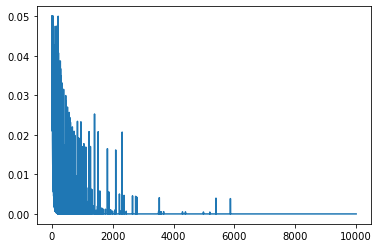

State Values:
------------------------------
-0.01|     | 0.17|-0.04|-0.04|
------------------------------
 0.02| 0.69| 0.77| 0.26|-0.03|
------------------------------
 0.05|     | 1.00|     |     |
------------------------------
     | 1.00| 0.80| 0.62| 0.46|

Policy:
------------------------------
  L  |     |  D  |  D  |  R  |
------------------------------
  R  |  D  |  D  |  L  |  L  |
------------------------------
  R  |     |  L  |     |     |
------------------------------
     |  U  |  L  |  L  |  L  |

State Visits:
Total states visited:  46526
------------------------------
 0.00|     | 0.00| 0.00| 0.00|
------------------------------
 0.00| 0.00| 0.00| 0.00| 0.00|
------------------------------
 0.00|     | 0.02|     |     |
------------------------------
     | 0.22| 0.23| 0.26| 0.27|



In [29]:
# Plot the biggest value change in each episode.
plt.plot(deltas)
plt.show()

# Determine the policy from Q and find the value of each state which corresponds to the maximum Q-value.
policy = {}
V = {}
for row in range(grid.height):
    for col in range(grid.width):
        # Determine the greedy action in each state.
        a, max_q = max_dict(Q[(row, col)])
        policy[(row, col)] = a
        # Get the value V for each state.
        V[(row, col)] = max_q

print("State Values:")
grid.print_state_values(V)
print("Policy:")
grid.print_policy(policy)
print("State Visits:")
grid.print_state_visits(state_visits)


## Task 2: Upper Confidence Bound (UCB)
<hr>

**TO DO (Task 2):** Complete the `act_ucb` function to act according to the upper confidence bound. Then copy and adapt the training loop from above. Evaluate the results.

In [30]:
def act_ucb(Qs, t, Ns, c=0.1):
    '''Selects an UpperConfidenceBound action given the action-values for a state, 
    the number of times a state has been visited and the number of times every action has been taken from
    the current state.'''
    Q_ucb = {}
    for key, val in Qs.items():
        Q_ucb[key] = val + c*np.sqrt(np.log10(t)/Ns[key]) 
    a, _ = max_dict(Q_ucb)
    return a

In [34]:
# Number of training episodes
EPISODES = 10000
# Discount Factor
GAMMA = 0.9
# Learning Rate
ALPHA = 0.05
# UCB Weight
C = 50.0
# Action space (Up, Down, Left, Right)
ALL_POSSIBLE_ACTIONS = ('U', 'D', 'L', 'R')

In [35]:
# Initialize an empty dictionary for the action-value function Q(s,a)
Q = {}
# Initialize an empty dictionary for the number of times action a has been chosen in state s.
action_visits = {}
# Initialize an empty dictionary for the number of times state s has been visited.
state_visits = {}

# For each state corresponding to each field in the environment, create a new dictionary inside the dictionaries.
for row in range(grid.height):
    for col in range(grid.width):
        Q[(row, col)] = {}
        action_visits[(row, col)] = {}
        state_visits[(row, col)] = 1
        # For each action in each state create a new entry in the dictonary setting its estimated value to 0.
        for a in ALL_POSSIBLE_ACTIONS:
            Q[(row, col)][a] = 0
            action_visits[(row, col)][a] = 1
            
# Keep track of the maximum value changes during each episode so we can print a learning curve after the training       
deltas = []


# Training Loop
# Play EPISODES number of episodes in the environment while learning after each step.
for e in range(EPISODES):
    # Every 1000 steps print the current episode number and epsilon
    if e % 1000 == 0:
        print("Episode: {}".format(e))

    # Set the starting state
    grid.reset()
    s = grid.get_current_state()

    biggest_change = 0
    while not grid.is_state_terminal():
        # Choose an action according to UCB.
        a = act_ucb(Q[s], state_visits[s], action_visits[s], c=C)
        r = grid.move(a)
        next_s = grid.get_current_state()
        
        # Update the state and action visits number.
        state_visits[s] += 1
        action_visits[s][a] += 1

        # Update Q(s,a)
        old_qsa = Q[s][a]
        next_a, max_q_next_s_a = max_dict(Q[next_s])
        # TODO: Implement the Q-Learning update formula from the pseudo code.
        Q[s][a] = Q[s][a] + ALPHA*(r + GAMMA*max_q_next_s_a - Q[s][a])
        biggest_change = max(biggest_change, np.abs(old_qsa - Q[s][a]))

        # Next state becomes current state.
        s = next_s

    deltas.append(biggest_change)

Episode: 0
Episode: 1000
Episode: 2000
Episode: 3000
Episode: 4000
Episode: 5000
Episode: 6000
Episode: 7000
Episode: 8000
Episode: 9000


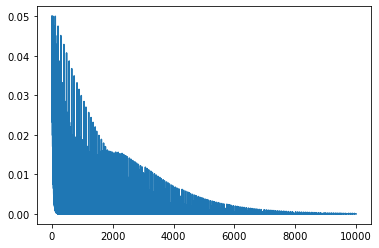

State Values:
------------------------------
 0.62|     | 0.62| 0.46| 0.31|
------------------------------
 0.80| 1.00| 0.80| 0.62| 0.46|
------------------------------
 1.00|     | 1.00|     |     |
------------------------------
     | 1.00| 0.80| 0.62| 0.46|

Policy:
------------------------------
  D  |     |  D  |  L  |  L  |
------------------------------
  R  |  D  |  D  |  L  |  L  |
------------------------------
  R  |     |  L  |     |     |
------------------------------
     |  U  |  U  |  L  |  L  |

State Visits:
Total states visited:  139029
------------------------------
 0.01|     | 0.02| 0.02| 0.01|
------------------------------
 0.01| 0.01| 0.03| 0.02| 0.01|
------------------------------
 0.00|     | 0.07|     |     |
------------------------------
     | 0.09| 0.15| 0.26| 0.28|



In [36]:
# Plot the biggest value change in each episode.
plt.plot(deltas)
plt.show()

# Determine the policy from Q and find the value of each state which corresponds to the maximum Q-value.
policy = {}
V = {}
for row in range(grid.height):
    for col in range(grid.width):
        # Determine the greedy action in each state.
        a, max_q = max_dict(Q[(row, col)])
        policy[(row, col)] = a
        # Get the value V for each state.
        V[(row, col)] = max_q

print("State Values:")
grid.print_state_values(V)
print("Policy:")
grid.print_policy(policy)
print("State Visits:")
grid.print_state_visits(state_visits)